In [67]:
# importing usual libraries

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# reading dataset

ds = pd.read_csv('conversion_data.csv')

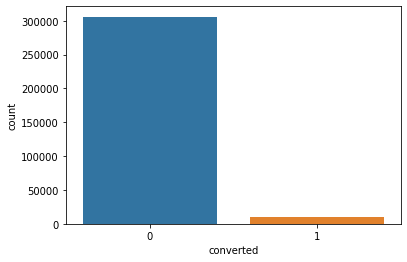

0    306000
1     10200
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.03225806451612903


In [5]:
# looking at conversions on our dataset 

sns.countplot(x = 'converted', data = ds)
plt.show()
converted_counts = ds['converted'].value_counts()
print(converted_counts)
print(f'proportions of 1s regarding the whole: {converted_counts[1] / converted_counts.sum()}')

In [6]:
# seperating our dataset into categorical, cotinous and target data

X_num = ds.columns[[1,2,4]]
X_cat = ds.columns[[0,3]]
y = ds.columns[5]

In [7]:
# brief look into proportion of our dataset amongst 'str' categorical variables country and source

source = ds['source'].value_counts()
country = ds['country'].value_counts()
for i in range(len(country)):
    print(country.index[i], 'proportion of data:', country[i] / country.sum())

print('------------------------------')
    
for i in range(len(source)):
    print(source.index[i], 'proportion of data:', source[i] / source.sum())

US proportion of data: 0.5632258064516129
China proportion of data: 0.24225806451612902
UK proportion of data: 0.1532258064516129
Germany proportion of data: 0.04129032258064516
------------------------------
Seo proportion of data: 0.49032258064516127
Ads proportion of data: 0.2806451612903226
Direct proportion of data: 0.22903225806451613


#### A brief look at our categorical variables: <br>
source - from where the user found the site,<br> country - from which country the user is connected

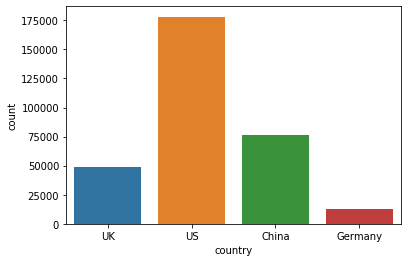

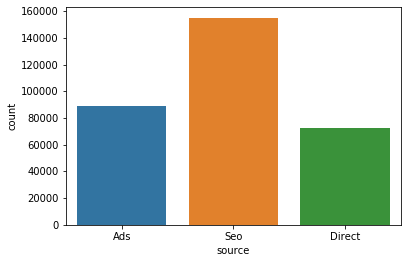

In [8]:
# barplots for our categorical variables

for i in X_cat:
    sns.countplot(x = i, data = ds)
    plt.show()

In [13]:
a = ds # china_n_paying # to switch between our dataset and our new china_n_paying model

# looking into source and country

Ads = a[(a.source == 'Ads')]
Seo = a[(a.source == 'Seo')]
Direct = a[(a.source == 'Direct')]

source_ds = [Ads, Seo, Direct]
source_label = ['Ads','Seo','Direct']

UK = a[(a.country == 'UK')]
US = a[(a.country == 'US')]
China = a[(a.country == 'China')]
Germany = a[(a.country == 'Germany')]

country_ds = [UK, US, China, Germany]
country_label = ['UK', 'US', 'China', 'Germany']

conversion count for UK


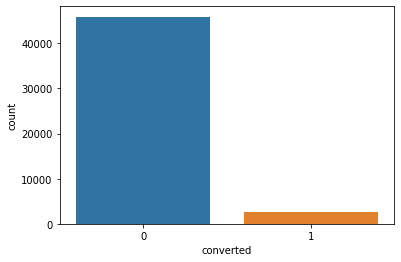

0    45900
1     2550
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.05263157894736842

conversion count for US


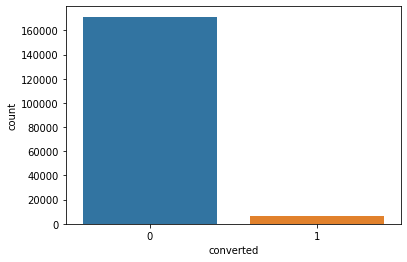

0    171360
1      6732
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.037800687285223365

conversion count for China


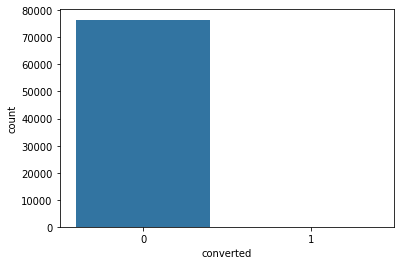

0    76500
1      102
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.0013315579227696406

conversion count for Germany


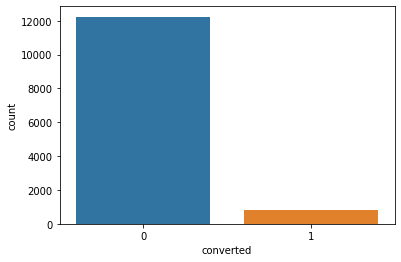

0    12240
1      816
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.0625



,source,proportion of conversions
0,UK,0.05263
1,US,0.0378
2,China,0.00133
3,Germany,0.0625


In [18]:
counts_country = [[],[]]

for i in range(4):
    print(f'conversion count for {country_label[i]}')
    sns.countplot(x = 'converted', data = country_ds[i])
    plt.show()
    converted_counts = country_ds[i]['converted'].value_counts()
    print(converted_counts)
    print(f'proportions of 1s regarding the whole: {converted_counts[1] / converted_counts.sum()}\n')
    counts_country[0].append(country_label[i])
    counts_country[1].append(round(converted_counts[1] / converted_counts.sum(), 5))
    
count_country = pd.DataFrame(np.array(counts_country).transpose(), columns = ['source','proportion of conversions'])
count_country

conversion count for Ads


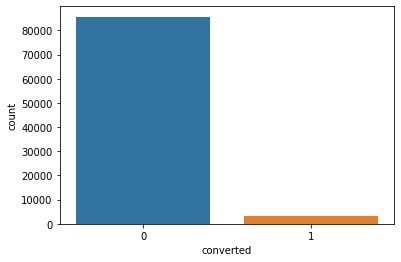

0    85680
1     3060
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.034482758620689655

conversion count for Seo


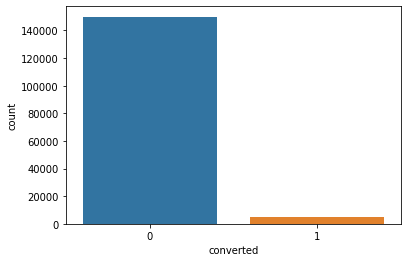

0    149940
1      5100
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.03289473684210526

conversion count for Direct


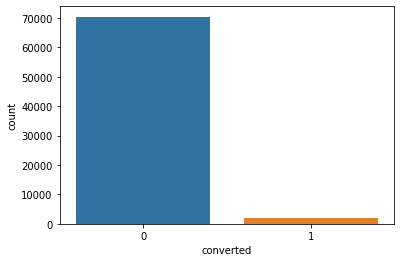

0    70380
1     2040
Name: converted, dtype: int64
proportions of 1s regarding the whole: 0.028169014084507043



,source,proportion of conversions
0,Ads,0.03448
1,Seo,0.03289
2,Direct,0.02817


In [15]:
counts_source = [[],[]]

for i in range(3):
    print(f'conversion count for {source_label[i]}')
    sns.countplot(x = 'converted', data = source_ds[i])
    plt.show()
    converted_counts = source_ds[i]['converted'].value_counts()
    print(converted_counts)
    print(f'proportions of 1s regarding the whole: {converted_counts[1] / converted_counts.sum()}\n')
    counts_source[0].append(source_label[i])
    counts_source[1].append(round(converted_counts[1] / converted_counts.sum(), 5))
    
count_source = pd.DataFrame(np.array(counts_source).transpose(), columns = ['source','proportion of conversions'])
count_source

#### After deciding that China has no impact on conversion, we decided to stop investing into them

In [24]:
# removing china from our ads and seo

china_paying = ds[(ds.country == 'China') & (ds.source != 'Direct')]

china_n_paying = ds[~ds.isin(china_paying)]
china_n_paying = china_n_paying.dropna()

source_country = pd.DataFrame(china_n_paying.groupby(['source','country'])['converted'].sum())
source_country[:]

converted
source country           
Ads    Germany      251.0
       UK           752.0
       US          2025.0
Direct China         24.0
       Germany      153.0
       UK           515.0
       US          1348.0
Seo    Germany      412.0
       UK          1283.0
       US          3359.0

In [37]:
# changing the dataframe for visualisation

countrys = []
sources = []

for i in range(len(source_country.index)):
    sources.append(source_country.index[i][0])
    countrys.append(source_country.index[i][1])

source_country['country'] = countrys
source_country['source'] = sources

In [52]:
# calculating proportional conversions per country

country_names = ['Germany','UK','US','China'] 
countries = [[0,4,7],[1,5,8],[2,6,9],[3]] 
sums = []
for i in range(4):
    sums.append(source_country.iloc[countries[i],0].sum())
    for j in countries[i]:
        source_country.iloc[j,0] = source_country.iloc[j,0] /sums[i]

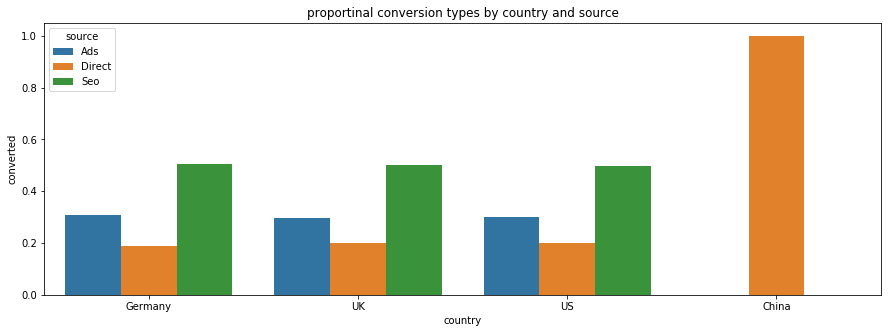

In [54]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'country', y = 'converted', data = source_country, hue = 'source')
plt.title('proportinal conversion types by country and source')
plt.show()

#### Now onto our numerical variables:<br>
age - age of user <br> new_user - whether it is the first time the use has come to the site <br>
total_pages_visited - total pages visited with the site

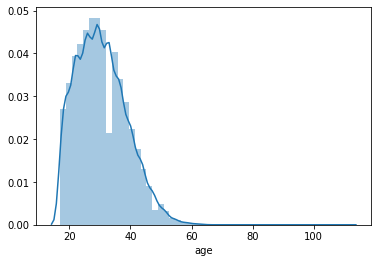

mean age for Ads: 30.497729945369834



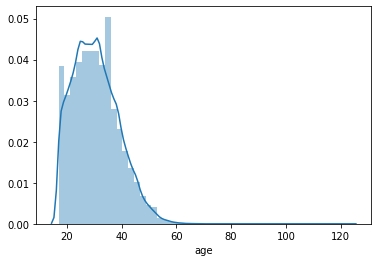

mean age for Seo: 30.549309563944085



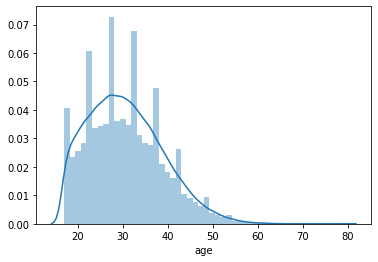

mean age for Direct: 30.56797845898923



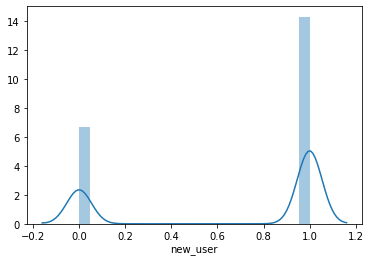

mean new_user for Ads: 0.6821923517765969



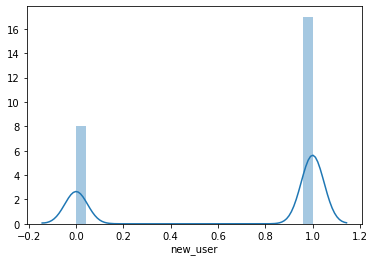

mean new_user for Seo: 0.6799305307248301



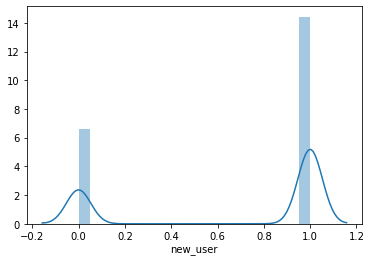

mean new_user for Direct: 0.6868544600938967



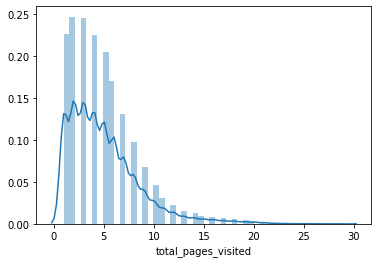

mean total_pages_visited for Ads: 5.0072939460248



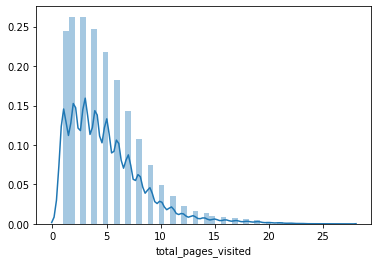

mean total_pages_visited for Seo: 4.987638555447719



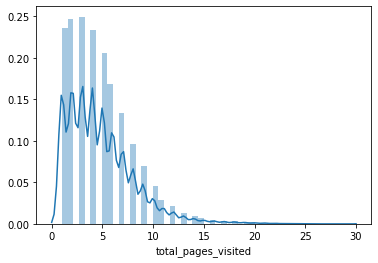

mean total_pages_visited for Direct: 4.816901408450704



In [28]:
# distribution plots for all our variables filtered by source

for j in X_num:
    for i in range(3):
        cntry_sample = source_ds[i]
        sns.distplot(cntry_sample[j])
        plt.show()
        print(f'mean {j} for {source_label[i]}: {cntry_sample[j].mean()}\n')

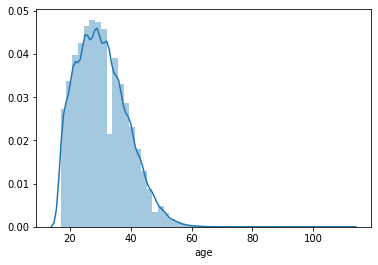

mean age for UK: 30.45153766769866



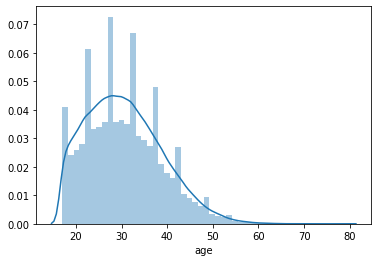

mean age for US: 30.566482492195046



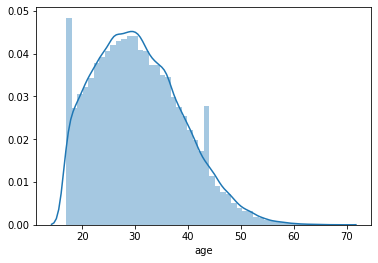

mean age for China: 30.672971985065665



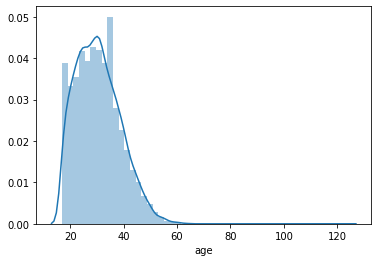

mean age for Germany: 30.44998468137255



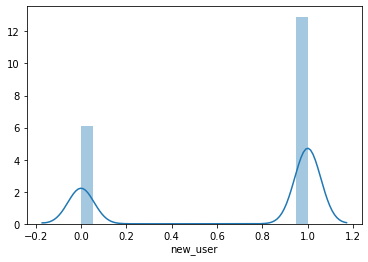

mean new_user for UK: 0.6798348813209494



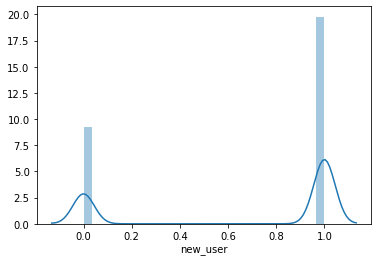

mean new_user for US: 0.6819845922332277



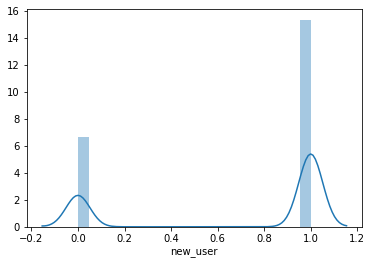

mean new_user for China: 0.6985196208976266



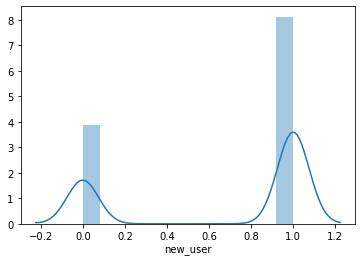

mean new_user for Germany: 0.6772365196078431



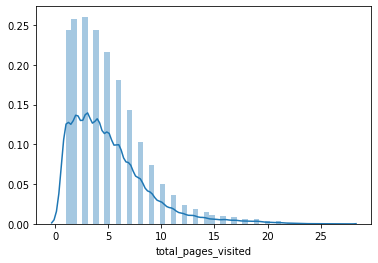

mean total_pages_visited for UK: 5.0821671826625385



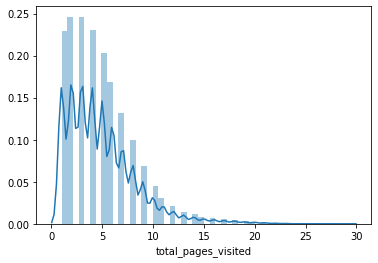

mean total_pages_visited for US: 4.930159692743077



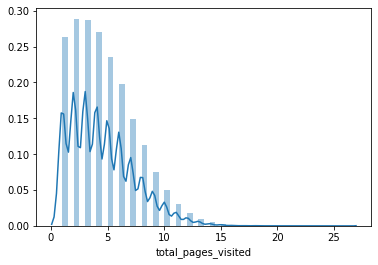

mean total_pages_visited for China: 4.553523406699564



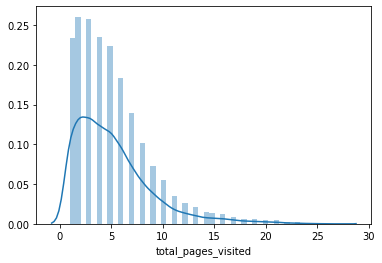

mean total_pages_visited for Germany: 5.190716911764706



In [56]:
# distribution plots for all our variables filtered by country

for j in X_num:
    for i in range(4):
        cntry_sample = country_ds[i]
        sns.distplot(cntry_sample[j])
        plt.show()
        print(f'mean {j} for {country_label[i]}: {cntry_sample[j].mean()}\n')

conversion age characteristics for UK: mean = 30.5878


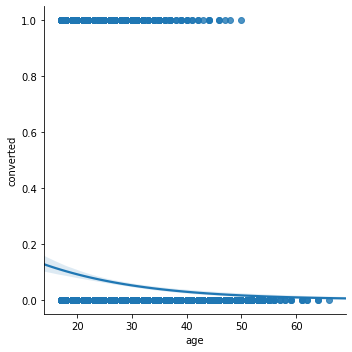

conversion age characteristics for US: mean = 30.4476


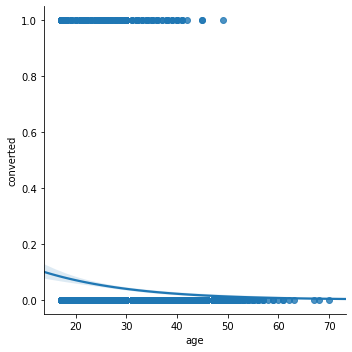

conversion age characteristics for China: mean = 30.7008


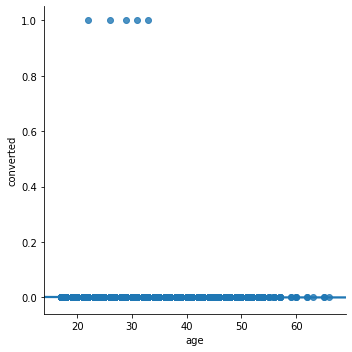

conversion age characteristics for Germany: mean = 30.494


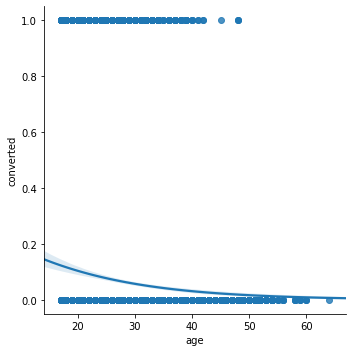

conversion new_user characteristics for UK: mean = 0.678


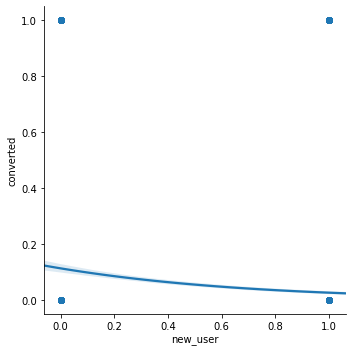

conversion new_user characteristics for US: mean = 0.6864


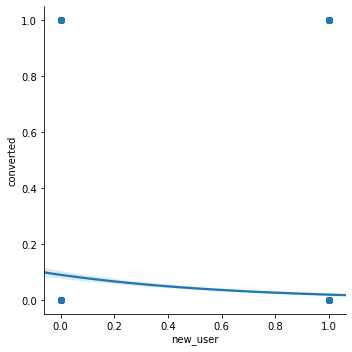

conversion new_user characteristics for China: mean = 0.698


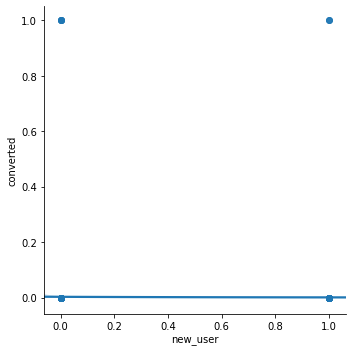

conversion new_user characteristics for Germany: mean = 0.6696


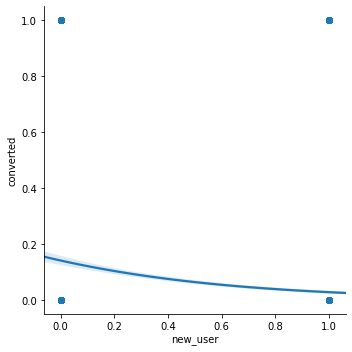

conversion total_pages_visited characteristics for UK: mean = 5.1014


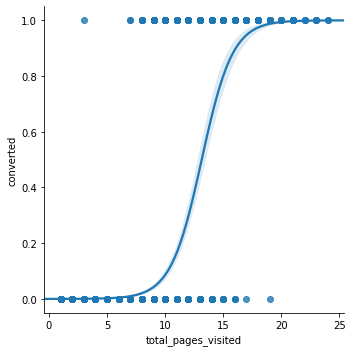

conversion total_pages_visited characteristics for US: mean = 4.9272


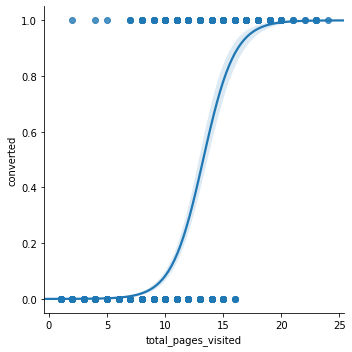

conversion total_pages_visited characteristics for China: mean = 4.5232


C:\Users\alecp\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


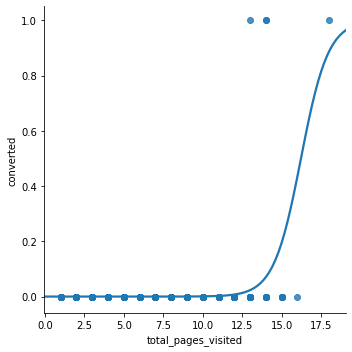

conversion total_pages_visited characteristics for Germany: mean = 5.165


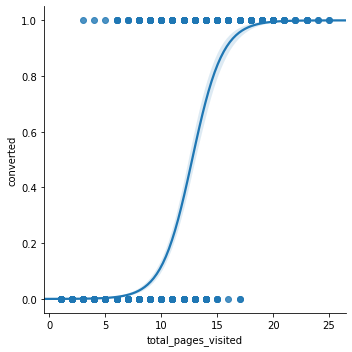

In [57]:
# sampling oversize categories and applying logistic regression to country differences in conversion vs variables

for j in X_num:
    for i in range(4):
        if len(country_ds[i]) > 5000:
            cntry_sample = country_ds[i].sample(5000)
        else:
            cntry_sample = country_ds[i]
        print(f'conversion {j} characteristics for {country_label[i]}: mean = {cntry_sample[j].mean()}')
        sns.lmplot(x = j, y = 'converted', data = cntry_sample, logistic = True)
        plt.show()

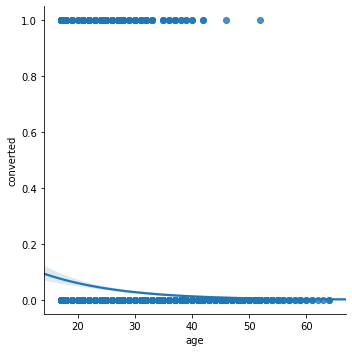

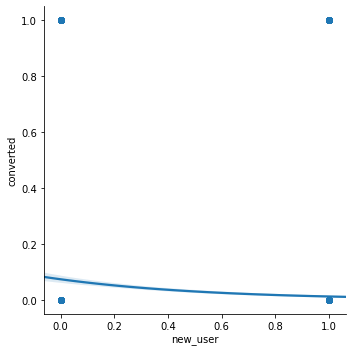

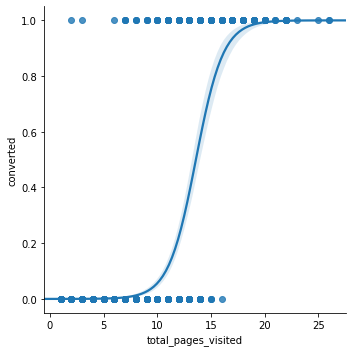

In [110]:
sampled = ds.sample(5000) # to avoid logisitc plotting from taking forever, which only apples to US and China
for i in X_num:
    sns.lmplot(x = i, y = 'converted', data = sampled, logistic = True)
    plt.show()

### we can start to see a clear indication towards conversion with total_pages_visited, with a slight indication in age and new_user

In [35]:
for i in country_ds
UKS = china_n_paying[china_n_paying.country == 'UK']

In [36]:
UKS.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [58]:
china_n_paying = china_n_paying.drop([90928,295581]) # dropping outlying ages, 112 and ~120 years

In [66]:
china_n_paying.age.min() # checking minimum age

17.0

US


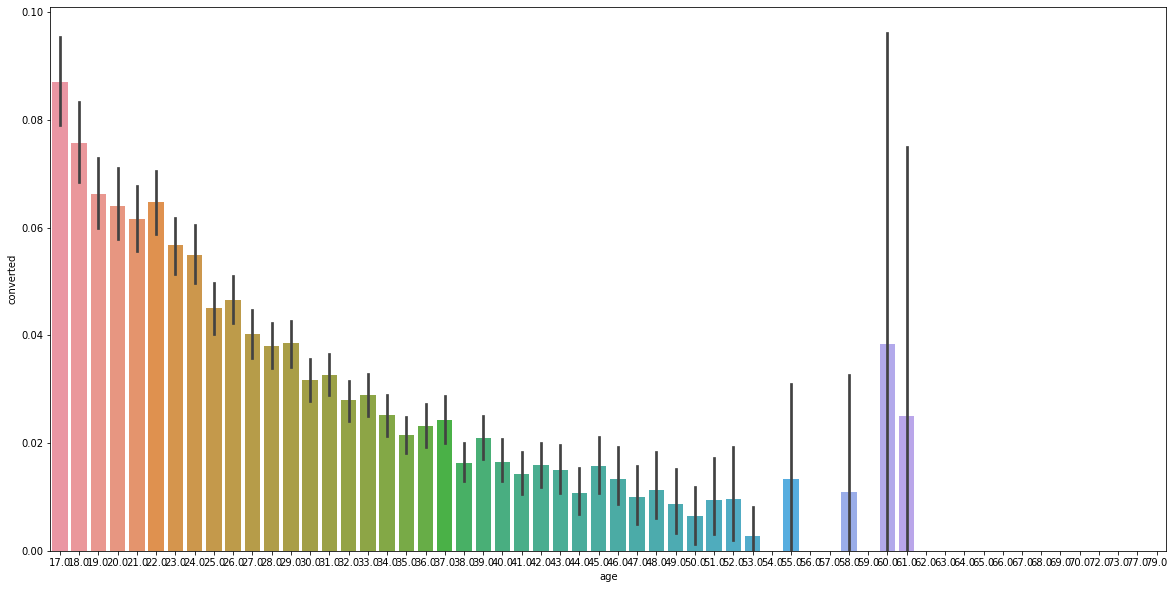

UK


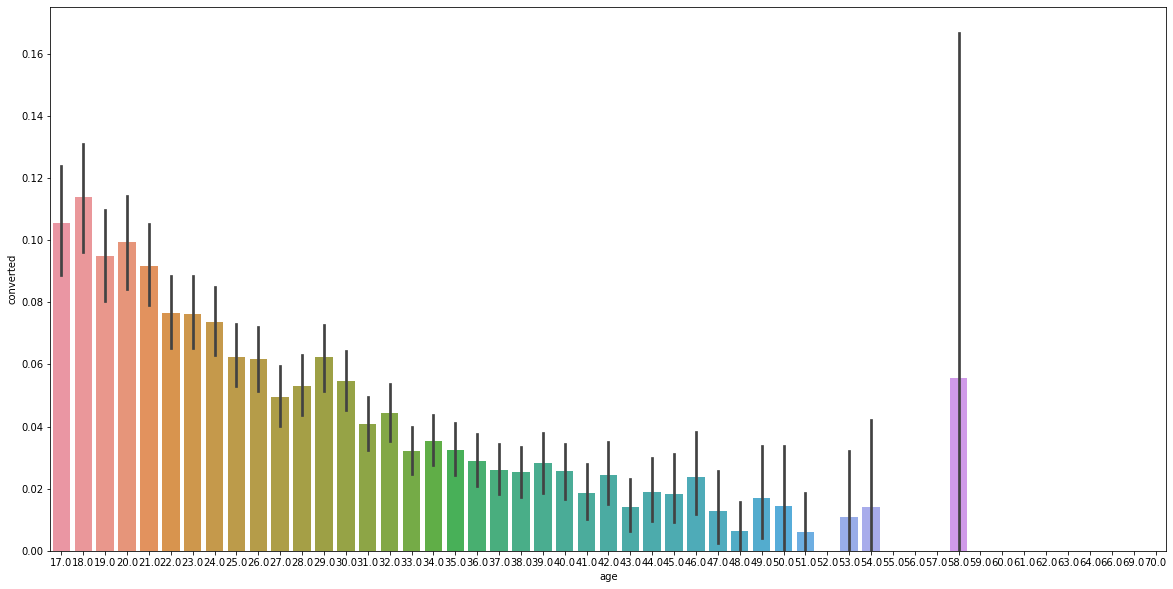

China


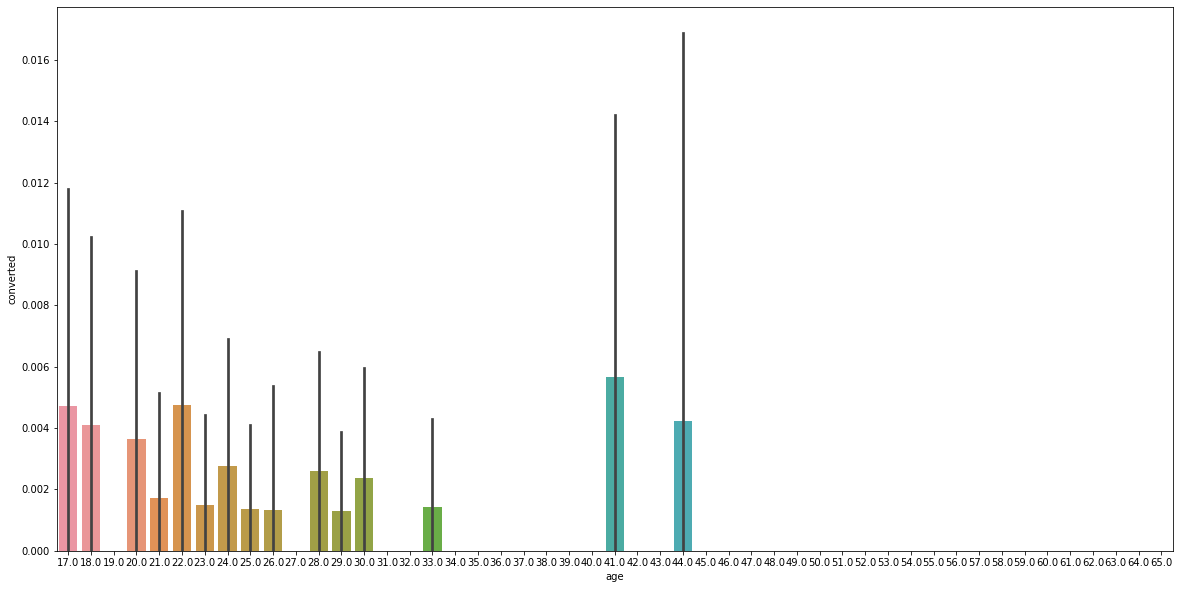

Germany


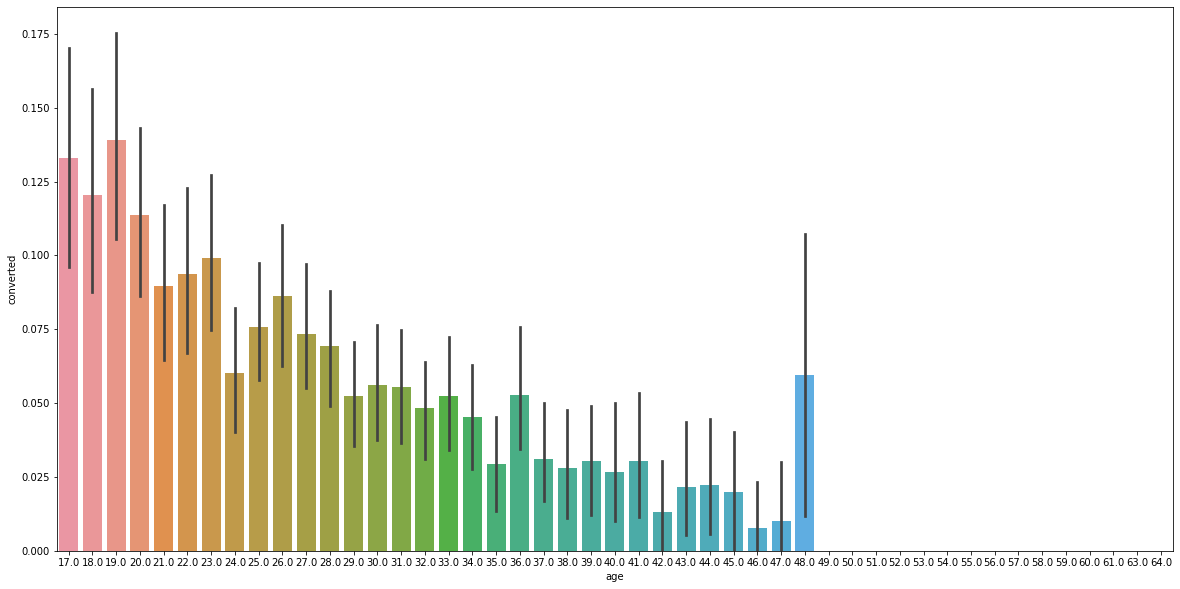

30.540416791475888


In [78]:
for i in range(len(country_ds)):   
    print(country_label[i])
    plt.figure(figsize = (20,10))
    sns.barplot(x = 'age', y = 'converted', data = country_ds[i])
    plt.show()
print(china_n_paying.age.mean())

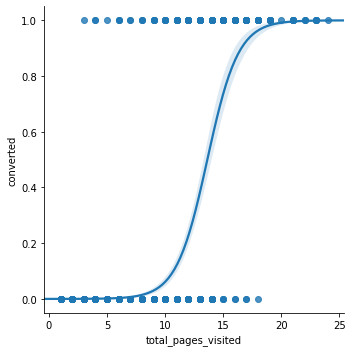

In [83]:
samples = china_n_paying.sample(5000)
sns.lmplot(x = 'total_pages_visited', y = 'converted', data = samples, logistic = True)
plt.show()

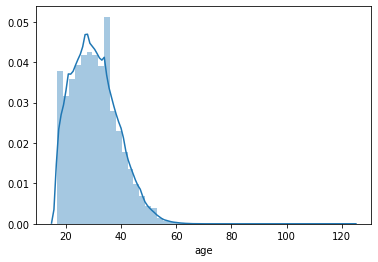

age mean: 30.569857685009488
-----------------


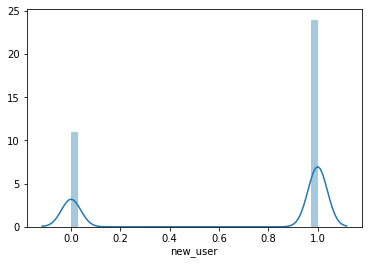

new_user mean: 0.6854648956356736
-----------------


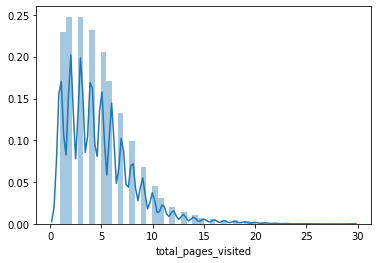

total_pages_visited mean: 4.872966476913346
-----------------


In [126]:
for i in X_num:
    sns.distplot(ds[i])
    plt.show()
    print(f'{i} mean: {ds[i].mean()}\n-----------------')

as new_user is binary it is well worth doing a count/ proportion rather than distplot

In [ ]:
# shortening our dataset by removing some of our converted = 0 variables



In [83]:
features_list = ds.columns[:-1]
target_variable = ds.columns[-1]
# Creation of a rapid logistic regression to ass the model
# Declaration fo target and features_list
#features_list = df_country_risk_model.columns.drop(target_variable).drop('country_count').drop('fraud_count').drop('country').drop('fraud_proportion').drop('country_proportion')
print(features_list)
X = ds.loc[:, features_list]
y = ds.loc[:, target_variable]
# Distinction of categorical features
# (string values, columns index for numpy use)
categorical_features_str = (X.select_dtypes(include=['object']).columns)
categorical_features = [X.columns.get_loc(i) for i in categorical_features_str]
print('categorical columns:',categorical_features)
# Distinction of numeric features 
numeric_features_str = X.columns.drop(categorical_features_str)
numeric_features = [X.columns.get_loc(i) for i in numeric_features_str]
print('numeric columns:',numeric_features)
X_train = X
y_train = y
# Declaration of the categorical and numeric transfomers
categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()
# Declaration of the feature encoder
feature_encoder = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]
)
# Fit of the encoder on X_train and transform of X_train
# Fit on X_train
feature_encoder.fit(X_train)
# Transformation of X_test
X_train = feature_encoder.transform(X_train)

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
categorical columns: [0, 3]
numeric columns: [1, 2, 4]


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

In [85]:
X_train.shape

(252960, 8)

In [86]:
X_test.shape

(63240, 8)

In [63]:
# Logistic Regression model

lr = LogisticRegression()
model = lr.fit(X_train,y_train)

C:\Users\alecp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,-1]
print(model.score(X_test, y_pred))

1.0


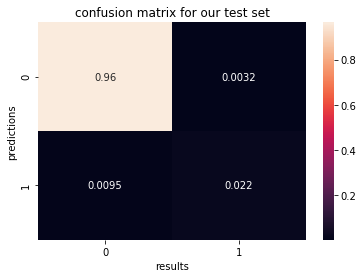

In [101]:
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum().sum()
sns.heatmap(cm, annot = True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('confusion matrix for our test set')
plt.ylabel('predictions')
plt.xlabel('results')
plt.show()

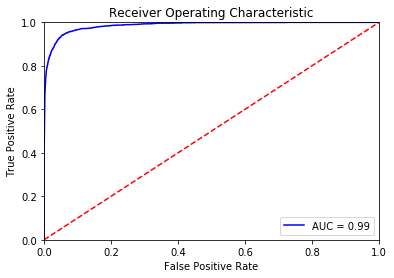

In [104]:
#plotting a ROC for our Logistic Regression

fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [91]:
# Random Forest Model: lets remove some of our converted = 0 to shrink our dataset a bit as well as even out our target


params = {'n_estimators': np.arange(250,350,10)}
gscv = GridSearchCV(RandomForestClassifier(min_samples_leaf = 2), param_grid = params, cv = 2, n_jobs = -1).fit(X_train, y_train)

In [94]:
gscv.best_params_

{'n_estimators': 330}

In [95]:
rfc = RandomForestClassifier(n_estimators = 330, min_samples_leaf = 2)
model_rfc = rfc.fit(X_train, y_train)

In [102]:
print('score:',model_rfc.score(X_test, y_test))
y_pred = model_rfc.predict(X_test)

score: 0.9860056925996205


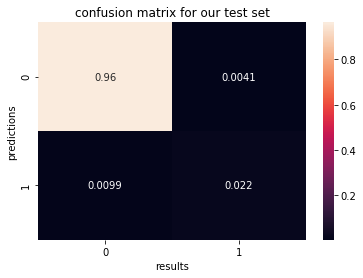

In [103]:
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum().sum()
sns.heatmap(cm, annot = True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('confusion matrix for our test set')
plt.ylabel('predictions')
plt.xlabel('results')
plt.show()